In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
train_df = pd.read_csv("Train_data.csv")

In [79]:
import missingno as msn

<Axes: >

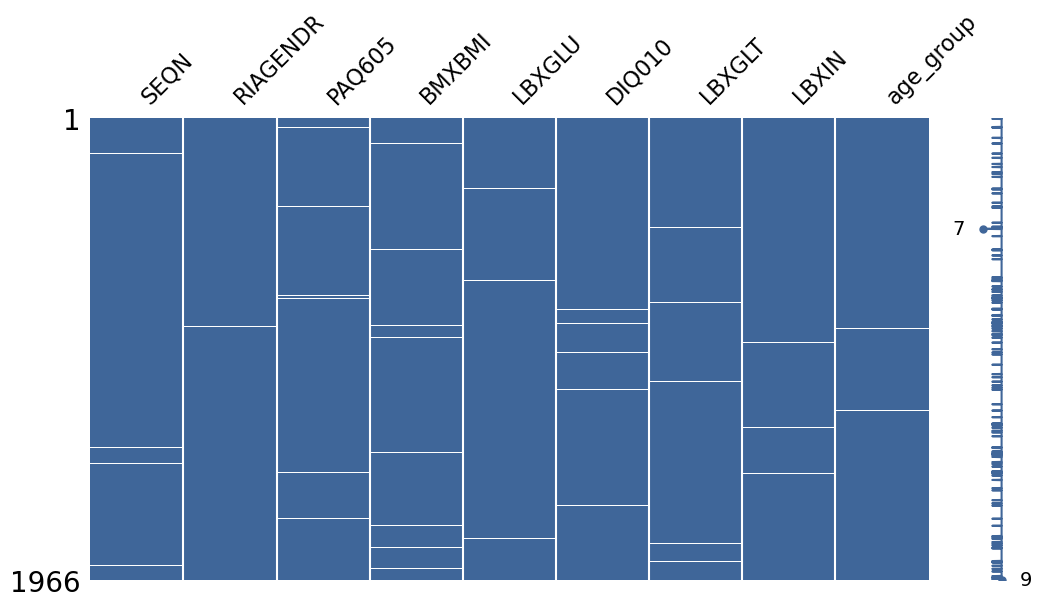

In [80]:
msn.matrix(train_df,figsize=(12,6),color=(0.25,0.4,0.6))

In [81]:
missing_per = train_df.isnull().mean() * 100
missing_table = pd.DataFrame({'Missing %': missing_per})
missing_table = missing_table[missing_table['Missing %']>0].sort_values(by='Missing %',ascending=False)

print("Missing value percents: ")
print(missing_table)

Missing value percents: 
           Missing %
RIAGENDR    0.915565
BMXBMI      0.915565
DIQ010      0.915565
age_group   0.712106
PAQ605      0.661241
LBXGLU      0.661241
SEQN        0.610376
LBXGLT      0.559512
LBXIN       0.457782


In [82]:
train_df.isnull().sum()

SEQN         12
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64

Value Counts:
 age_group
Adult     1638
Senior     314
NaN         14
Name: count, dtype: int64
Class Distribution(percent):
  age_group
Adult     83.316378
Senior    15.971516
NaN        0.712106
Name: proportion, dtype: float64


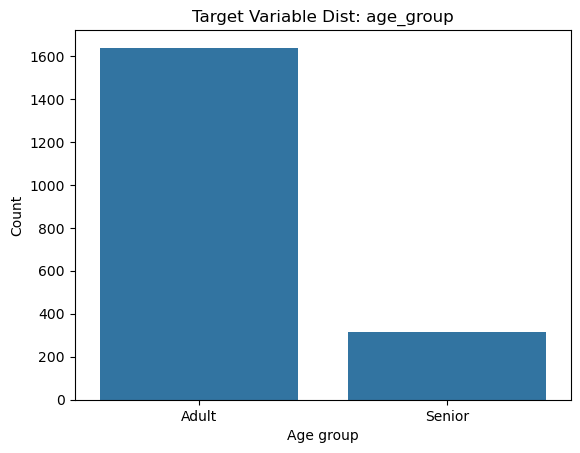

In [83]:
print("Value Counts:\n", train_df['age_group'].value_counts(dropna=False))
print("Class Distribution(percent):\n ",train_df['age_group'].value_counts(normalize=True, dropna=False)*100)

sns.countplot(data=train_df,x='age_group')
plt.title("Target Variable Dist: age_group")
plt.xlabel("Age group")
plt.ylabel("Count")
plt.show()

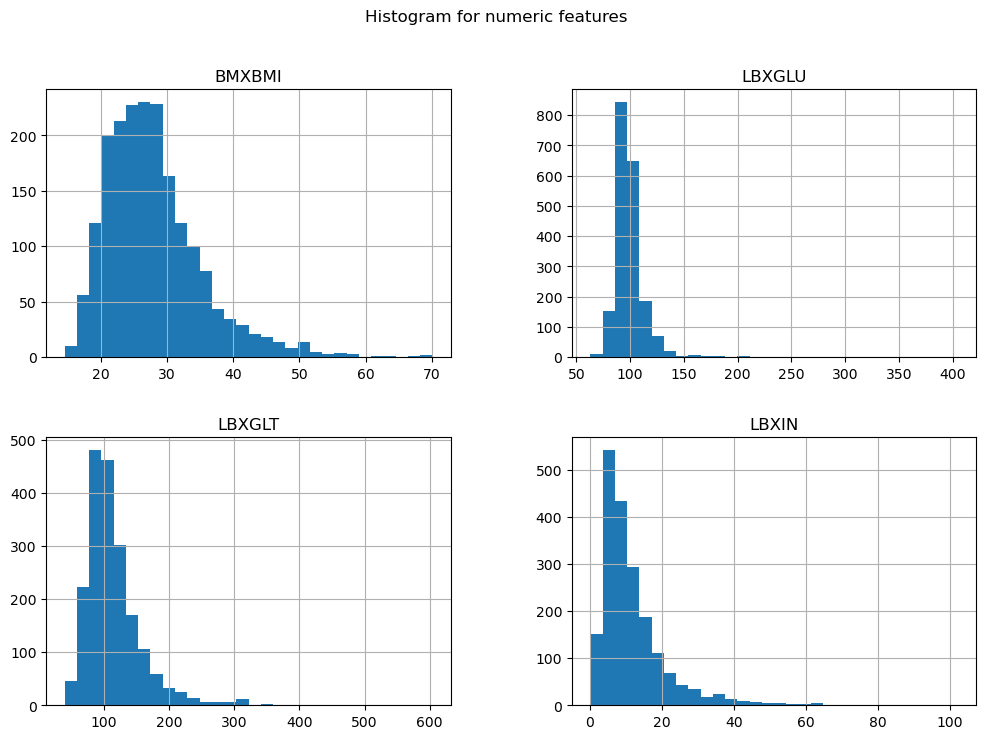

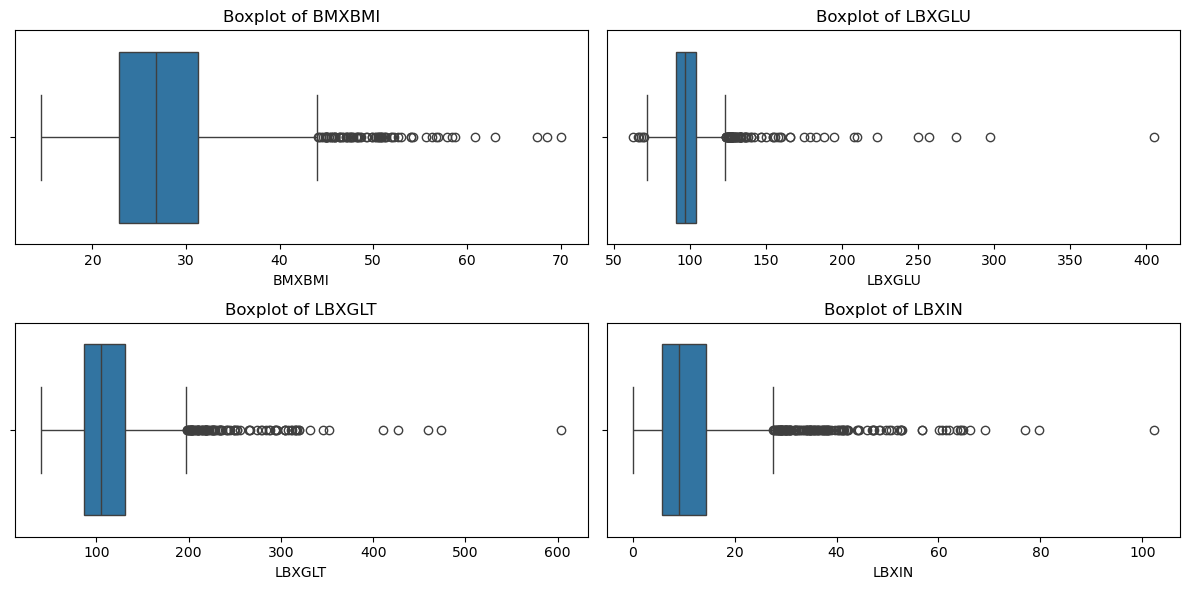

In [84]:
num_features = ['BMXBMI','LBXGLU','LBXGLT','LBXIN']

#Histogram
train_df[num_features].hist(bins=30, figsize=(12,8))
plt.suptitle("Histogram for numeric features")
plt.show()

#Boxplot
plt.figure(figsize=(12,6))
for i,feature in enumerate(num_features, 1):
    plt.subplot(2,2,i)
    sns.boxplot(data=train_df, x=feature)
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()


----------RIAGENDR-----------
RIAGENDR
2.0    994
1.0    954
NaN     18
Name: count, dtype: int64


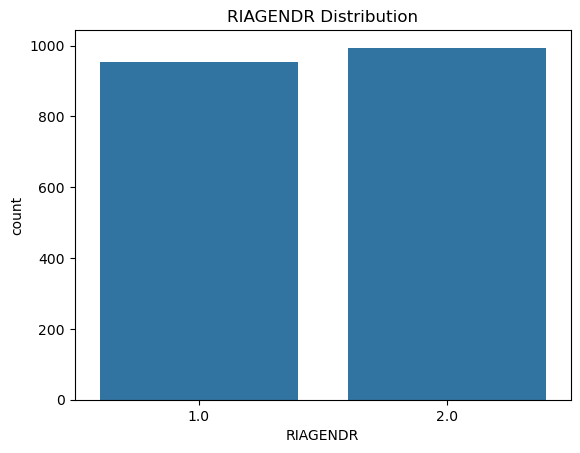


----------PAQ605-----------
PAQ605
2.0    1606
1.0     346
NaN      13
7.0       1
Name: count, dtype: int64


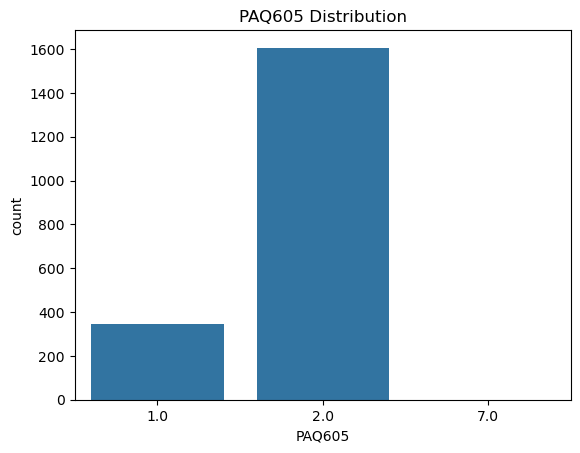


----------DIQ010-----------
DIQ010
2.0    1879
3.0      50
1.0      19
NaN      18
Name: count, dtype: int64


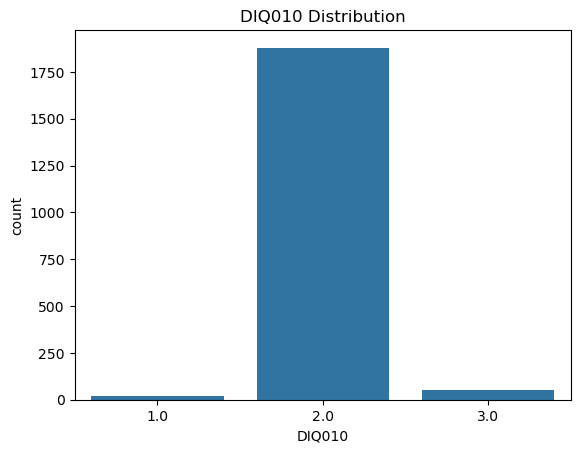

In [85]:
cat_features = ['RIAGENDR','PAQ605','DIQ010']

for col in cat_features:
    print(f"---------{col}---------")
    print(train_df[col].value_counts(dropna=False))
    sns.countplot(data=train_df,x=col)
    plt.title(f"{col} Distribution")
    plt.show()
    

In [86]:
train_df = train_df[train_df['PAQ605'] != 7]

train_df = train_df[train_df['age_group'].notna()]

from sklearn.impute import SimpleImputer

cat_imputer = SimpleImputer(strategy='most_frequent')
train_df[cat_features] = cat_imputer.fit_transform(train_df[cat_features])

num_imputer = SimpleImputer(strategy ='median')
train_df[num_features] = num_imputer.fit_transform(train_df[num_features])

print(train_df.isnull().sum())

SEQN         12
RIAGENDR      0
PAQ605        0
BMXBMI        0
LBXGLU        0
DIQ010        0
LBXGLT        0
LBXIN         0
age_group     0
dtype: int64


In [87]:
train_df = train_df.drop('SEQN',axis=1)

In [88]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: encoding target variable

train_df['age_group'] = train_df['age_group'].str.strip().str.capitalize()
print(train_df['age_group'].unique())
train_df['age_group'] = train_df['age_group'].map({'Adult': 0, 'Senior': 1})

print(train_df['age_group'])


['Adult' 'Senior']
0       0
1       0
2       0
3       0
4       0
       ..
1961    0
1962    0
1963    0
1964    0
1965    0
Name: age_group, Length: 1951, dtype: int64


In [89]:
X = train_df.drop(columns=['age_group'])
y = train_df['age_group']
num_features = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
cat_features_label = ['RIAGENDR', 'PAQ605', 'DIQ010']
cat_features_onehot = ['DIQ010'] 

# creating transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_label_transformer = 'passthrough' 

categorical_onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Using column transformer
# a:(label encoding version)
preprocessor_label = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_label_transformer, cat_features_label)
])

# b:(one-hot DIQ010 only version)
preprocessor_onehot = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat1', 'passthrough', ['RIAGENDR', 'PAQ605']),
    ('cat2', categorical_onehot_transformer, ['DIQ010'])
])


In [90]:
# Splitting the data (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# training with  label encoding
pipe_label = Pipeline(steps=[
    ('preprocessor', preprocessor_label),
    ('classifier', LogisticRegression(max_iter=1000))
])
pipe_label.fit(X_train, y_train)
y_pred_label = pipe_label.predict(X_val)

#training with one-hot encoding
pipe_onehot = Pipeline(steps=[
    ('preprocessor', preprocessor_onehot),
    ('classifier', LogisticRegression(max_iter=1000))
])
pipe_onehot.fit(X_train, y_train)
y_pred_onehot = pipe_onehot.predict(X_val)

#evaluation to choose the best pipeline
print("=== Label Encoding Results ===")
print(classification_report(y_val, y_pred_label))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_label))

print("=== One-Hot Encoding Results ===")
print(classification_report(y_val, y_pred_onehot))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_onehot))


=== Label Encoding Results ===
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       328
           1       0.50      0.06      0.11        63

    accuracy                           0.84       391
   macro avg       0.67      0.53      0.51       391
weighted avg       0.79      0.84      0.78       391

Confusion Matrix:
 [[324   4]
 [ 59   4]]

=== One-Hot Encoding Results ===
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       328
           1       0.50      0.06      0.11        63

    accuracy                           0.84       391
   macro avg       0.67      0.53      0.51       391
weighted avg       0.79      0.84      0.78       391

Confusion Matrix:
 [[324   4]
 [ 59   4]]


In [91]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#preprocessing 
X_train_encoded = preprocessor_onehot.fit_transform(X_train)
X_val_encoded = preprocessor_onehot.transform(X_val)

#resampling train data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)


from xgboost import XGBClassifier

# XGBoost 
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_resampled, y_resampled)

y_pred_xgb = xgb_clf.predict(X_val_encoded)

# Evaluation
print("=== XGBoost + SMOTE ===")
print(classification_report(y_val, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_xgb))


C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost + SMOTE ===
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       328
           1       0.37      0.37      0.37        63

    accuracy                           0.80       391
   macro avg       0.62      0.62      0.62       391
weighted avg       0.80      0.80      0.80       391

Confusion Matrix:
 [[288  40]
 [ 40  23]]


In [92]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb_clf, X_resampled, y_resampled, cv=5, scoring='f1')
print("Cross val F1 score: ", scores)
print("Mean F1 score: ", scores.mean())


C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encode

Cross-validated F1 scores: [0.69026549 0.89591078 0.90810811 0.875      0.88      ]
Mean F1 score: 0.8498568751005834


In [ ]:
#getting the best params 


from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_resampled, y_resampled)

print("Best Params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


In [94]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# using best params 
xgb_final = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

#fitting to smote transformed training data
xgb_final.fit(X_resampled, y_resampled)

#predicting on val set
y_pred_final = xgb_final.predict(X_val_encoded)

# Evaluatiton
print(classification_report(y_val, y_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_final))

f1_scores_final = cross_val_score(xgb_final, X_resampled, y_resampled, cv=5, scoring='f1')
print("Cross-validated F1 scores:", f1_scores_final)
print("Mean F1 score:", f1_scores_final.mean())


C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== FINAL MODEL VALIDATION REPORT ===
              precision    recall  f1-score   support

           0       0.88      0.84      0.85       328
           1       0.31      0.38      0.34        63

    accuracy                           0.76       391
   macro avg       0.59      0.61      0.60       391
weighted avg       0.78      0.76      0.77       391

Confusion Matrix:
 [[274  54]
 [ 39  24]]


C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\yasha\.conda\envs\tf-gpu\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encode

Cross-validated F1 scores: [0.70824053 0.86085343 0.89208633 0.86956522 0.88203267]
Mean F1 score: 0.8425556366012612


In [95]:
#using threshold optimisation on the test data

test_df = pd.read_csv("Test_data.csv")

X_test_encoded = preprocessor_onehot.transform(test_df)

test_probs = xgb_final.predict_proba(X_test_encoded)[:, 1]
final_preds = (test_probs >= best_threshold).astype(int)

submission_df = pd.DataFrame({'age_group': final_preds})
submission_df.to_csv('submission_final_thresholded3.csv', index=False)


Best threshold: 0.26
Best F1 score at threshold: 0.4023


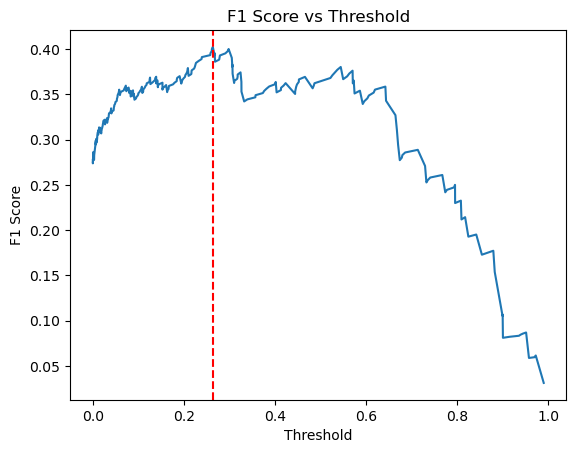

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       328
           1       0.32      0.56      0.40        63

    accuracy                           0.73       391
   macro avg       0.61      0.66      0.62       391
weighted avg       0.81      0.73      0.76       391



In [76]:
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt

# getting  probabilities from XGBoost
y_probs = xgb_clf.predict_proba(X_val_encoded)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)

#computing f1
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best F1 score at threshold: {f1_scores[best_idx]:.4f}")

plt.plot(thresholds, f1_scores[:-1])
plt.axvline(best_threshold, linestyle='--', color='red')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.show()

y_pred_optimal = (y_probs >= best_threshold).astype(int)
print(classification_report(y_val, y_pred_optimal))
